In [1]:
import numpy as np

import torch

import fnn

import sys
sys.path.insert(0, '../01_code')
from simple_Hamiltonian_systems import HarmonicOscillator

In [2]:
n = 1000 # training data
epochs = 1000

X_train, Y_train = fnn.generate_training_data(n)

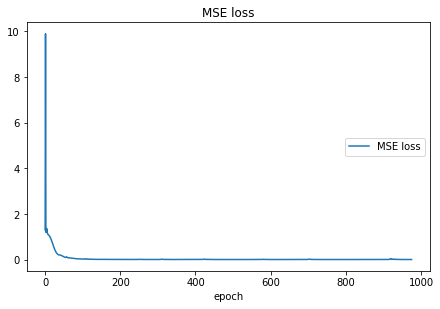

MSE loss
	MSE loss         	 (min:    0.000, max:    1.299, cur:    0.000)


In [3]:
# train FNN with MSE loss

mse = torch.nn.MSELoss()
def mse_loss(y_target, model, x):
    y_pred = model(x)
    return mse(y_pred, y_target)

model_mse = fnn.train_fnn(mse_loss, X_train, Y_train, epochs=epochs)

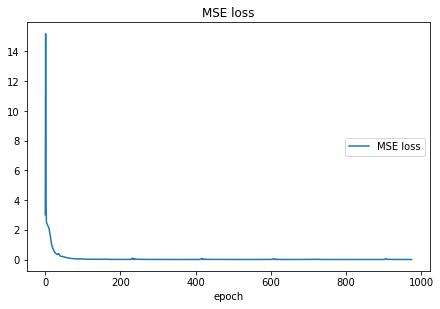

MSE loss
	MSE loss         	 (min:    0.000, max:    3.021, cur:    0.002)


In [4]:
# train FNN with symplectic soft loss

J = torch.tensor([[0., 1.], [-1., 0.]])

def compute_jacobian(outputs: torch.Tensor, inputs: torch.Tensor):
    k = outputs.size()[0]
    n = inputs.size()[0]
    
    res = torch.zeros(k, n)

    for i in range(0, n):
        grad_outputs = torch.zeros(n)
        grad_outputs[i] = 1.
        grad = torch.autograd.grad(outputs, inputs, grad_outputs=grad_outputs, retain_graph=True)[0]
        res[:,i:i+1] = grad.reshape(2,1)

    return res.t() # transpose because autograd.grad calculates J.t() * v

def symplectic_loss(y_target, model, x):
    mse_d = 0.
    mse_s = 0.  

    n = x.size()[0]
    for i in range(0,n):
        x_i = x[i]
        y_target_i = y_target[i]
        y_pred_i = model(x_i)
        jacobian = compute_jacobian(y_pred_i, x_i)

        mse_d += torch.sum((y_pred_i - y_target_i) ** 2)

        symp = jacobian.t().mm(J).mm(jacobian) - J
        mse_s += torch.sum(symp ** 2)
        
    w = 0.1
    return 1/n*(mse_d + w*mse_s)

model_soft = fnn.train_fnn(symplectic_loss, X_train, Y_train, epochs=epochs)

In [5]:
## Harmonic oscillator
model = HarmonicOscillator()
mu = {'m': 1., 'k': 1., 'f': 0., 'q0': 1., 'p0': 0.}

# compute solution for all t in [0, pi]
X_exact, _ = model.solve(0, np.pi, np.pi/1e3, mu)
X_mse_loss, _ = fnn.integrate(model_mse)
X_soft_loss, _ = fnn.integrate(model_soft)

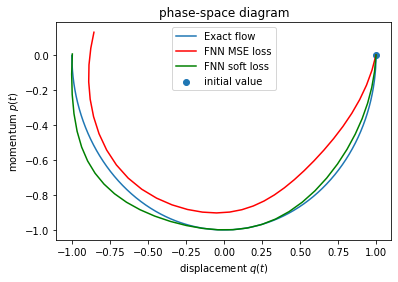

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes()

ax.plot(X_exact[0,:], X_exact[1,:], label='Exact flow')
ax.plot(X_mse_loss[:,0], X_mse_loss[:,1], 'r', label='FNN MSE loss')
ax.plot(X_soft_loss[:,0], X_soft_loss[:,1], 'g', label='FNN soft loss')
ax.scatter(X_exact[0,0], X_exact[1,0], marker='o', label='initial value')
ax.set_xlabel(r'displacement $q(t)$')
ax.set_ylabel(r'momentum $p(t)$')
ax.legend()
ax.set_title('phase-space diagram')

fig.show()